# Equal-sized Bins Clustering
Commutative-ly combine splats of similar depth to reduce sorting and improve performance.

In [1]:
# Path to the CSV file containing the collected splats.
CSV_FILE_PATH = "data/collected_splats.csv"

# Number of bins to use.
NUMBER_OF_BINS = 5

In [2]:
import numpy as np
import polars as pl

## Load Data From CSV

In [3]:
# Define the column names.
column_names = [f"gaussian_{i}_{part}" for i in range(500) for part in ["alpha", "depth", "color_r", "color_g", "color_b"]]
column_names = ["sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g", "background_b"] + column_names

# Define schema.
schema_dict = {name: pl.Float32 for name in column_names}
schema_dict["sample_index"] = pl.UInt32
schema_dict["background_r"] = pl.UInt8
schema_dict["background_g"] = pl.UInt8
schema_dict["background_b"] = pl.UInt8
schema = pl.Schema(schema_dict)

In [4]:
# Load data.
data = pl.scan_csv(CSV_FILE_PATH, schema=schema)

## Extract the Splats from the data.

In [5]:
from PIL import Image

In [6]:
# Get the output image and size.
ground_truth_image = Image.open("data/gt.png")
image_width, image_height = ground_truth_image.size

print(f"Image size: {image_width} x {image_height}")

Image size: 1264 x 832


In [7]:
# Collect the raw splats.
raw_splats = data.select(
    pl.all().exclude("sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g", "background_b")).collect().to_numpy()

# Reshape into splats table per pixel.
splats = raw_splats.reshape((image_height * image_width, raw_splats.shape[1] // 5, 5))

# Cluster Splats.
- Create N bins from the minimum non-zero depth to the maximum depth.
- For each pixel, collect splats into bins based on their depth.
- In each bin, sum the premultiplied colors and sum the alphas.

In [8]:
# Compute the minimum and maximum depth of the image.
depth_values = splats[:, :, 1]
depth_values = depth_values[depth_values > 0]
min_depth = np.min(depth_values)
max_depth = np.max(depth_values)

print(f"Min depth: {min_depth}, Max depth: {max_depth}")
print(f"Each bin will be {(max_depth - min_depth) / NUMBER_OF_BINS} units wide.")

Min depth: 1.2029399871826172, Max depth: 11.86460018157959
Each bin will be 2.1323320865631104 units wide.


In [9]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [10]:
def cluster_splats(splats_to_cluster, min_bin_depth, max_bin_depth, number_of_bins):
    """Cluster splats into bins based on their depth."""
    def collect_splats(pixel_splats):
        # Define output bins.
        pixel_output = np.zeros((number_of_bins, 4))
        
        # Loop through each splat.
        for splat in pixel_splats:
            # Skip transparent splats.
            if splat[0] == 0:
                continue
            
            # Compute the bin index.
            bin_index = int((splat[1] - min_bin_depth) / (max_bin_depth - min_bin_depth) * (number_of_bins - 1))

            # Log color.
            pixel_output[bin_index, 0] += splat[0]

            # Log cumulative alpha.
            pixel_output[bin_index, 1:] += splat[0] * splat[2:]
        
        # Return computation.
        return pixel_output
    
    # Parallelize the clustering process.
    return Parallel(n_jobs=-1)(delayed(collect_splats)(pixel_splats) for pixel_splats in tqdm(splats_to_cluster))

## Do the Clustering.
1. Sorted splats straight from the CSV file.
2. Shuffled splats in each pixel.

In [11]:
# Cluster the splats (sorted).
clustered_splats = cluster_splats(splats, min_depth, max_depth, NUMBER_OF_BINS)

  0%|          | 0/1051648 [00:00<?, ?it/s]

In [12]:
# Shuffle the splats in each pixel.
rng = np.random.default_rng()
rng.shuffle(splats, axis=1)

# Cluster shuffled splats.
cluster_shuffled_splats = cluster_splats(splats, min_depth, max_depth, NUMBER_OF_BINS)

  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Bins.
- Compute the color of each pixel using the clustered splats.
- Use the alpha-over blending formula with each bin from front to back.
- The color of each bin is the sum of the premultiplied colors divided by the sum of alphas.

In [13]:
def compute_image_from_bins(binned_splats):
    """Compute the color of each pixel using the clustered splats."""
    def alpha_over_pixel(pixel_bins):
        # Define the transmittance and pixel color for the first bin.
        transmittance = 1.0
        pixel_color = np.zeros(3) if not pixel_bins[0, 0] else pixel_bins[0, 1:] / pixel_bins[0, 0]
        
        # Loop through remaining bins.
        for k in range(1, NUMBER_OF_BINS):
            # Skip transparent bin.
            if not pixel_bins[k, 0]:
                continue
            # Exit once the transmittance is basically zero.
            if transmittance <= 0.001:
                break
            
            # Compute the transmittance.
            transmittance *= 1 - min(1, pixel_bins[k - 1, 0])
            
            # Compute the pixel color.
            pixel_color += pixel_bins[k, 1:] / pixel_bins[k, 0] * transmittance

        # Return the computed pixel color.
        return pixel_color
    
    # Compute the color of each pixel.
    return Parallel(n_jobs=-1)(delayed(alpha_over_pixel)(pixel_bins) for pixel_bins in tqdm(binned_splats))

## Do the Computation.

In [14]:
# Sorted image.
computed_image = compute_image_from_bins(clustered_splats)

  0%|          | 0/1051648 [00:00<?, ?it/s]

In [15]:
# Shuffled image.
computed_shuffled_image = compute_image_from_bins(cluster_shuffled_splats)

  0%|          | 0/1051648 [00:00<?, ?it/s]

## Display the Results.

In [16]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.004824937166572].


(np.float64(-0.5), np.float64(1263.5), np.float64(831.5), np.float64(-0.5))

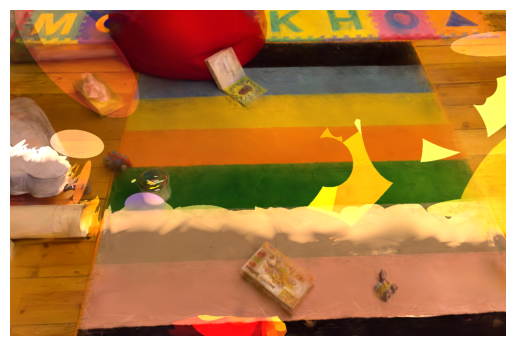

In [17]:
# Display the sorted image.
plt.imshow(np.array(computed_image).reshape((image_height, image_width, 3)))
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.004824937166572].


(np.float64(-0.5), np.float64(1263.5), np.float64(831.5), np.float64(-0.5))

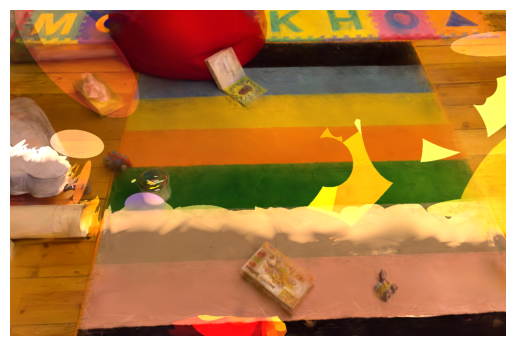

In [18]:
# Display the shuffled image.
plt.imshow(np.array(computed_shuffled_image).reshape((image_height, image_width, 3)))
plt.axis('off')